# C3.ai COVID-19 Data Lake Deep Dive

## Clinical and Demographic Data Exploration

Last updated: September 14, 2020.

This Jupyter notebook shows how clinical and demographic datasets integrated into the C3.ai COVID-19 Data Lake can be used to create fast and powerful analyses. See the [API documentation](https://c3.ai/covid-19-api-documentation/) for more details.

Please contribute your questions, answers and insights on [Stack Overflow](https://www.stackoverflow.com). Tag `c3ai-datalake` so that others can view and help build on your contributions. For support, please send email to: [covid@c3.ai](mailto:covid@c3.ai).



## Table of Contents
- [Helper Methods for Accessing the API](#helper)
- [Case Counts Across States and Counties](#case_counts)
- [Age Demographics](#age)
- [Clinical Resources](#medical)
- [Vaccination Rates](#vaccines)
- [Race Demographics](#demographics)

In [1]:
import csv
import datetime
import re
from functools import partial

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 7)

Ensure that you have a recent version of pandas (>= 1.0.0).

In [2]:
print("pandas version", pd.__version__)
assert pd.__version__[0] >= "1", "To use this notebook, upgrade to the newest version of pandas. See https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html for details."

pandas version 1.1.3


<a id="helper"></a>
### Helper Methods for Accessing the API

The helper methods in `c3aidatalake.py` convert a JSON response from the C3.ai APIs to a Pandas DataFrame. You may wish to view the code in `c3aidatalake.py` before using the quickstart examples.

In [3]:
import c3aidatalake

<a id="case_counts"></a>
### Case Counts Across States and Counties

To start, we can retrieve data for US states and counties from the data lake. To look at COVID-19 cases and deaths, we will pull these statistics for a specified list of state IDs and reshape the dataframe to observe changes over time.

In [4]:
states = [
    'Alabama_UnitedStates','Alaska_UnitedStates','Arizona_UnitedStates',
    'Arkansas_UnitedStates','California_UnitedStates','Colorado_UnitedStates',
    'Connecticut_UnitedStates','Delaware_UnitedStates','DistrictofColumbia_UnitedStates',
    'Florida_UnitedStates','Georgia_UnitedStates','Hawaii_UnitedStates',
    'Idaho_UnitedStates','Illinois_UnitedStates','Indiana_UnitedStates',
    'Iowa_UnitedStates','Kansas_UnitedStates','Kentucky_UnitedStates',
    'Louisiana_UnitedStates','Maine_UnitedStates','Maryland_UnitedStates',
    'Massachusetts_UnitedStates','Michigan_UnitedStates','Minnesota_UnitedStates',
    'Mississippi_UnitedStates','Missouri_UnitedStates','Montana_UnitedStates',
    'Nebraska_UnitedStates','Nevada_UnitedStates','NewHampshire_UnitedStates',
    'NewJersey_UnitedStates','NewMexico_UnitedStates','NewYork_UnitedStates',
    'NorthCarolina_UnitedStates','NorthDakota_UnitedStates','Ohio_UnitedStates',
    'Oklahoma_UnitedStates','Oregon_UnitedStates','Pennsylvania_UnitedStates',
    'PuertoRico_UnitedStates','RhodeIsland_UnitedStates','SouthCarolina_UnitedStates',
    'SouthDakota_UnitedStates','Tennessee_UnitedStates','Texas_UnitedStates',
    'Utah_UnitedStates','Vermont_UnitedStates','Virginia_UnitedStates',
    'Washington_UnitedStates','WestVirginia_UnitedStates','Wisconsin_UnitedStates',
    'Wyoming_UnitedStates'
]

In [5]:
counties = c3aidatalake.fetch(
    "outbreaklocation",
    {
        "spec" : {
            "include" : "id",
            "filter" : "contains(id, 'UnitedStates') && locationType == 'county'"
        }
    },
    get_all = True
).id.tolist()

Johns Hopkins University (JHU) provides confirmed COVID-19 cases and deaths by state.

In [6]:
today = '2020-07-21'

metrics = [
    "JHU_ConfirmedCases",
    "JHU_ConfirmedDeaths"
]

complete_timeseries = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : states,
            "expressions" : metrics,
            "start" : "2020-02-15",
            "end" : today,
            "interval" : "DAY",
        }
    },
    get_all = True
)

In [7]:
state_from_location = lambda x: "_".join(x.split('_')[-2:]).replace("_UnitedStates", "")

def reshapeTimeseries(timeseries_df):

    reshaped_ts = pd.melt(
        timeseries_df, 
        id_vars=['dates'], 
        value_vars=[x for x in timeseries_df.columns if re.match('.*\.data', x)]
    ).rename(columns={"value": "data", "dates": "date"})

    reshaped_ts["state"] = (
        reshaped_ts["variable"]
        .str.replace("\..*", "")
        .apply(state_from_location)
    )

    reshaped_ts["metric"] = (
        reshaped_ts["variable"]
        .str.replace(".*UnitedStates\.", "")
        .str.replace("\..*", "")
    )
    

    return reshaped_ts

In [8]:
state_timeseries = reshapeTimeseries(complete_timeseries)
state_timeseries.head()

,date,variable,data,state,metric
0,2020-02-15,Alabama_UnitedStates.JHU_ConfirmedCases.data,0,Alabama,JHU_ConfirmedCases
1,2020-02-16,Alabama_UnitedStates.JHU_ConfirmedCases.data,0,Alabama,JHU_ConfirmedCases
2,2020-02-17,Alabama_UnitedStates.JHU_ConfirmedCases.data,0,Alabama,JHU_ConfirmedCases
3,2020-02-18,Alabama_UnitedStates.JHU_ConfirmedCases.data,0,Alabama,JHU_ConfirmedCases
4,2020-02-19,Alabama_UnitedStates.JHU_ConfirmedCases.data,0,Alabama,JHU_ConfirmedCases


In [9]:
state_cases = (
    state_timeseries
    .loc[state_timeseries.date > '2020-03-10']
    .groupby(['date', 'state', 'metric'])['data']
    .sum()
    .unstack('metric')
    .reset_index()
)
state_cases['death_rate'] = state_cases.apply(
    lambda x: 0 if x.JHU_ConfirmedCases == 0
    else x.JHU_ConfirmedDeaths / x.JHU_ConfirmedCases,
    axis=1
)

Some states have had very large outbreaks of COVID-19. We can focus on those states to understand how viral transmission transitions between high and low growth.

In [10]:
large_outbreak_states = (
    state_cases
    .loc[state_cases.date == max(state_cases.date)]
    .query('JHU_ConfirmedCases > 100000')
    .sort_values('JHU_ConfirmedCases', ascending=False)
    .state.tolist()
)

large_outbreak_states

['NewYork',
 'California',
 'Florida',
 'Texas',
 'NewJersey',
 'Illinois',
 'Georgia',
 'Arizona',
 'Massachusetts',
 'Pennsylvania',
 'NorthCarolina']

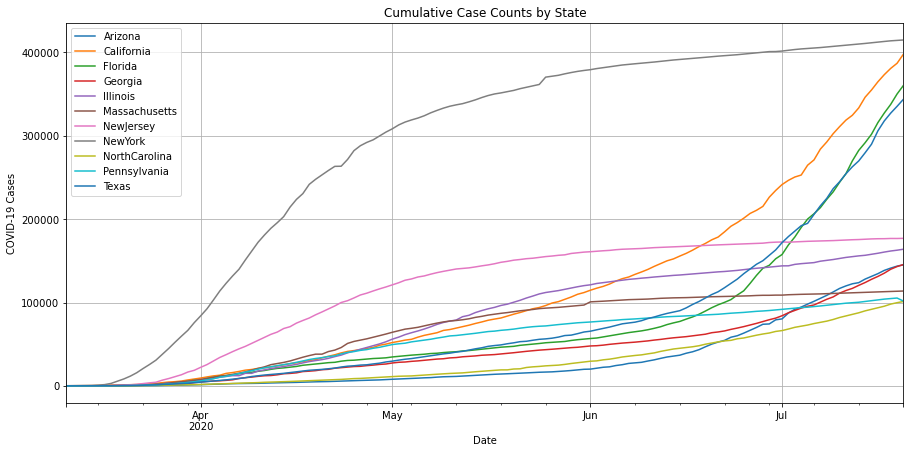

In [11]:
state_case_plot = (
    state_cases
    .loc[state_cases.state.isin(large_outbreak_states)]
    .set_index('date')
    .groupby(['state'])['JHU_ConfirmedCases']
    .plot()
)

plt.grid(True)
plt.legend()
plt.title("Cumulative Case Counts by State")
plt.xlabel("Date")
plt.ylabel("COVID-19 Cases")
plt.show()

We can see some states had early outbreaks in April and May while others were just experiencing a rapid increase in cases in June and July. While the case counts for New York State seem large, the bulk of infections occurred in New York City. Let's see if there are other states where one county explains a large number of cases.

In [12]:
large_outbreak_counties = [
    x for x in counties 
    for y in large_outbreak_states[:7]
    if f"{y}_UnitedStates" in x and y != "NewYork"
]

In [13]:
select_counties = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : large_outbreak_counties,
            "expressions" : ["JHU_ConfirmedCases"],
            "start" : "2020-02-15",
            "end" : today,
            "interval" : "DAY",
        }
    },
    get_all = True
)

# Note: makes large number of API calls and may take a couple minutes to complete

In [14]:
county_timeseries = reshapeTimeseries(select_counties)
county_timeseries['location'] = county_timeseries.variable.str.split('.').str[0]

county_cases = (
    county_timeseries
    .groupby(['date', 'location', 'state', 'metric'])['data']
    .sum()
    .unstack('metric')
    .reset_index()
)

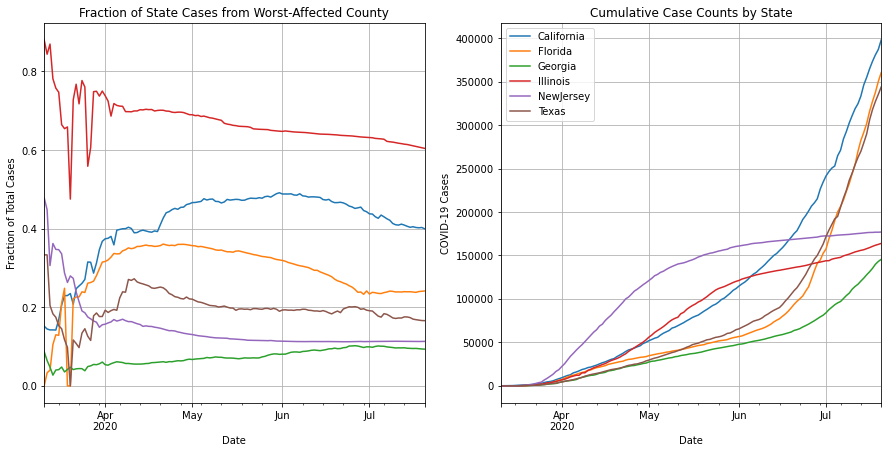

In [15]:
maxCounties = (
    county_cases.loc[
        county_cases
         .loc[county_cases.date == max(county_cases.date)]
         .groupby('state')['JHU_ConfirmedCases']
         .idxmax()]
    .location
    .tolist()
)

countydata = (state_cases.merge(
    county_cases[county_cases.location.isin(maxCounties)]
    [['state', 'date', 'location', 'JHU_ConfirmedCases']]
    .rename(columns={'JHU_ConfirmedCases': 'countyCases'}),
    on=['state', 'date'])
)

countydata['percTopCounty'] = countydata.countyCases / countydata.JHU_ConfirmedCases


plt.subplot(121)
(
    countydata
    .set_index('date')
    .groupby('state')
    .percTopCounty.plot()
)
plt.grid(True)

plt.title("Fraction of State Cases from Worst-Affected County")
plt.xlabel("Date")
plt.ylabel("Fraction of Total Cases")


plt.subplot(122)
(
    state_cases
    .loc[state_cases.state.isin(
        set(map(lambda x: x.split("_")[1], large_outbreak_counties))
    )]
    .set_index('date')
    .groupby('state')
    .JHU_ConfirmedCases.plot()
)

plt.grid(True)
plt.legend()
plt.title("Cumulative Case Counts by State")
plt.xlabel("Date")
plt.ylabel("COVID-19 Cases")
plt.show()


Interestingly, the states exhibit quite distinct patterns. A city like Chicago held a significant share of Illinois' cases before the other counties caught up with additional viral spread. On the other hand, California had a growing share of its cases in Los Angeles county through June before reversing as LA increased restrictions and other counties saw significant transmission. States like Illinois with concentrated outbreaks might be able to enforce targeted lockdowns to limit COVID-19 spread, while states like Georgia with dispersed outbreaks require a wider geographic approach.

<a id="age"></a>
### Age Demographics

The C3.ai COVID-19 Data Lake contains demographic information accessed through the PopulationData type. We can pull some population statistics from US Census data to understand how the age distribution of a state or county relates to its susceptibility to the virus.

In [16]:
population_limits = (
    f"contains(parent, 'UnitedStates') &&" # US data
    "(populationAge == '>=65' || populationAge == 'Total' || populationAge == '>=18') && " # Limit age groups
    "gender == 'Male/Female' && year == 2018 && origin == 'United States Census'" # From 2018 estimates
)

census = c3aidatalake.fetch(
    "populationdata",
    {
      "spec": {
        "filter": population_limits
      }
    },
    get_all = True
)

census['state'] = census['parent.id'].apply(state_from_location)
census = census.rename(columns={'parent.id': 'location'})

In [17]:
census_cols = [
    "populationAge",
    "value",
    "location",
    "state"
]

census_by_state = (
    census[census_cols]
    .loc[census.state.isin(map(lambda x: x.replace("_UnitedStates", ""), states))]
    .groupby(["state", "populationAge"])['value']
    .sum()
    .unstack("populationAge")
    .reset_index()
)

census_by_state.columns = ['state', 'over18', 'over65', 'total']
census_by_state['olderPerc'] = census_by_state.over65 * 100 / census_by_state.total
census_by_state['youngerPerc'] = (census_by_state.total - census_by_state.over18) * 100 / census_by_state.total

By dividing the over 65 and under 18 populations by the total population for each state, we get useful metrics that can be compared across population sizes.

In [18]:
census_by_state.head()

,state,over18,over65,total,olderPerc,youngerPerc
0,Alabama,3798031.0,826894.0,4887871.0,16.917263,22.296824
1,Alaska,588192.0,93336.0,781305.0,11.946167,24.716724
2,Arizona,5528989.0,1258250.0,7171646.0,17.544787,22.904881
3,Arkansas,2310645.0,511827.0,3013825.0,16.982638,23.331813
4,California,30567090.0,5669025.0,39557045.0,14.331265,22.726559


People under 18 make up a large percentage of most counties. Below we see that there is a direct relationship between the older and younger populations as you might expect.

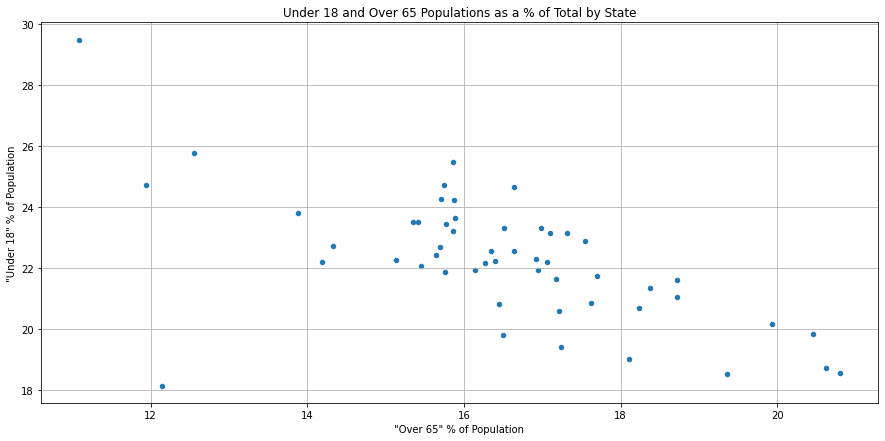

In [19]:
census_by_state.plot.scatter(x='olderPerc', y='youngerPerc')

plt.grid(True)
plt.title("Under 18 and Over 65 Populations as a % of Total by State")
plt.xlabel('"Over 65" % of Population')
plt.ylabel('"Under 18" % of Population')

plt.show()

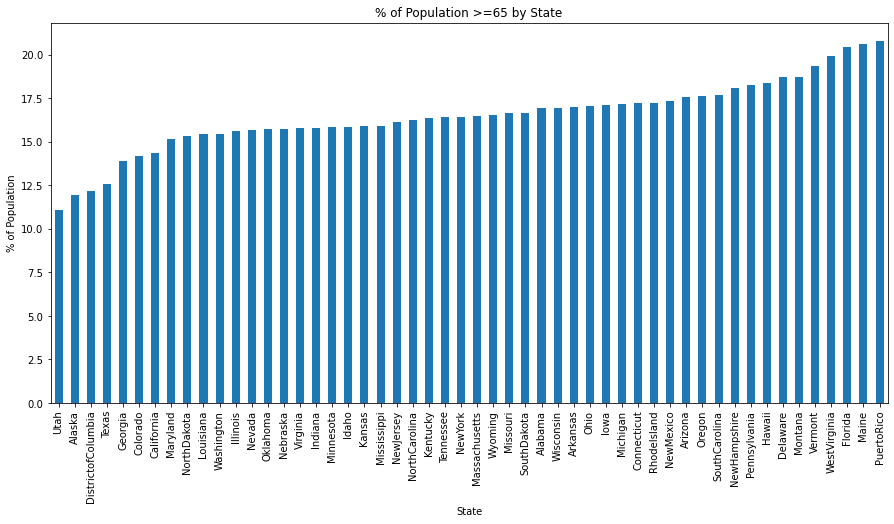

In [20]:
census_by_state.sort_values('olderPerc').plot.bar(x='state', y='olderPerc', rot=90, legend=False)

plt.title("% of Population >=65 by State")
plt.xlabel("State")
plt.ylabel("% of Population")
plt.show()

States span close to a 10% range in the over 65 proportion of their populations. Let's see how states below and above the median on this measure of age fared with the pandemic.

In [21]:
olderStates = (
    census_by_state
    .loc[census_by_state.olderPerc > census_by_state.olderPerc.median()]
    .state.tolist()
)

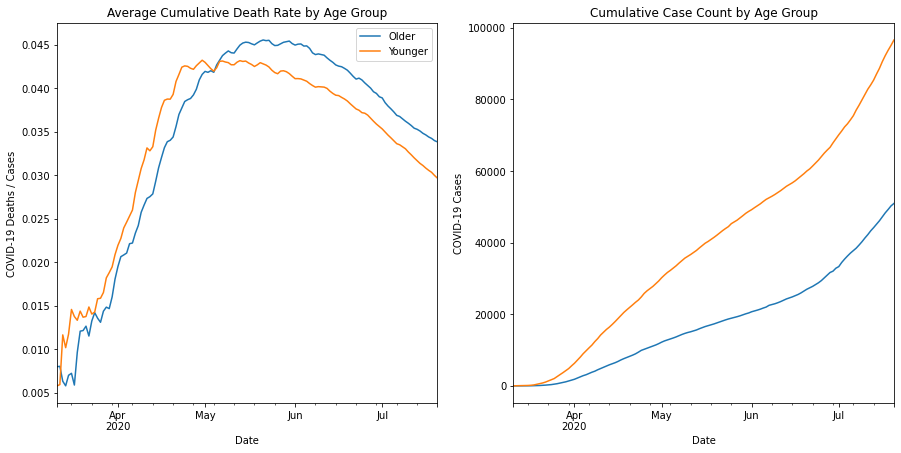

In [22]:
state_cases['olderState'] = state_cases.state.apply(
    lambda x: 'Older' if x in olderStates else 'Younger'
)

plt.subplot(121)
(
    state_cases
    .groupby(['date','olderState'])
    .death_rate.mean()
    .reset_index()
    .set_index('date')
    .groupby(['olderState'])
    .death_rate
    .plot(legend=True)
)
plt.title("Average Cumulative Death Rate by Age Group")
plt.xlabel("Date")
plt.ylabel("COVID-19 Deaths / Cases")

plt.subplot(122)
(
    state_cases
    .groupby(['date','olderState'])
    .JHU_ConfirmedCases.mean()
    .reset_index()
    .set_index('date')
    .groupby(['olderState'])
    .JHU_ConfirmedCases
    .plot()
)
plt.title("Cumulative Case Count by Age Group")
plt.xlabel("Date")
plt.ylabel("COVID-19 Cases")

plt.show()

Early in the pandemic, the cumulative death rate rose in sync in both older and younger states, but on average the younger states have reduced their death rate earlier and from a lower peak. Let's look at just the states with the largest outbreaks.

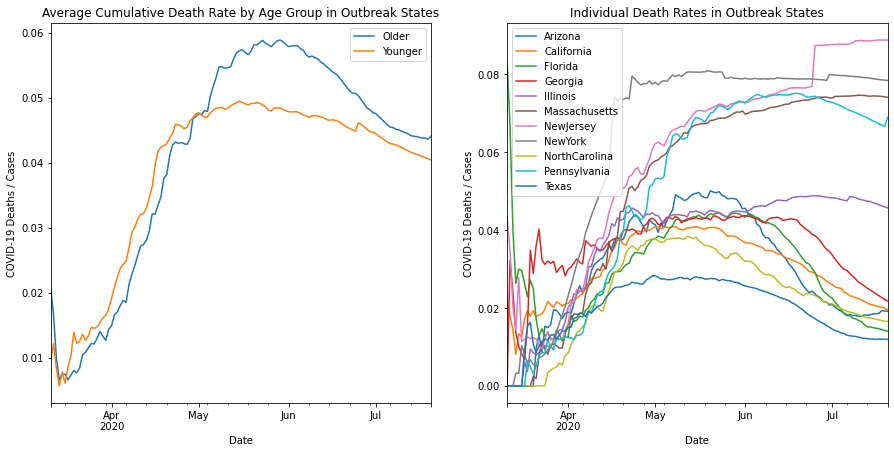

In [23]:
plt.subplot(121)
(
    state_cases
    .loc[state_cases.state.isin(large_outbreak_states)]
    .groupby(['date','olderState'])
    .death_rate.mean()
    .reset_index()
    .set_index('date')
    .groupby(['olderState'])['death_rate']
    .plot(legend=True)
)

plt.title("Average Cumulative Death Rate by Age Group in Outbreak States")
plt.xlabel("Date")
plt.ylabel("COVID-19 Deaths / Cases")


plt.subplot(122)
(
    state_cases
    .loc[state_cases.state.isin(large_outbreak_states)]
    .set_index('date')
    .groupby(['state'])['death_rate']
    .plot(legend=True)
)

plt.title("Individual Death Rates in Outbreak States")
plt.xlabel("Date")
plt.ylabel("COVID-19 Deaths / Cases")

plt.show()

The large outbreak states show a similar patten, but the older states have a much more extreme curve peaking near 6%. Looking at the individual death rate trends among states, one group appears to have had growing death rates in April and May before bringing them back down in June. Other states like Pennsylvania and Massachusetts seem to have had a much harder time in reducing their death rates.

<a id="medical"></a>
### Clinical Resources

Local access to medical care and a population's existing level of health are important factors in community’s susceptibility to the pandemic. We can retrieve data on vaccination rates and hospital resources to understand the preparedness of each county.

In [24]:
vax_coverage = c3aidatalake.fetch(
    "vaccinecoverage",
    {
        "spec" : {
            "filter" : "demographicClass == ' All Residents'"
        }
    },
    get_all = True
)
vax_coverage = vax_coverage.loc[
    vax_coverage['location.id'].isin(states)
]

state_vax_coverage = (
    vax_coverage
    .loc[vax_coverage.year == 2017]
    .groupby(['location.id', 'vaccineDetails'])['value']
    .mean()
    .apply(partial(round, ndigits=2))
    .unstack("vaccineDetails")
    .reset_index()
    .rename(columns={'location.id': 'state'})
    
)
state_vax_coverage.state = state_vax_coverage.state.apply(state_from_location)

state_vax_coverage.columns = [
    'state', 
    'InfluenzaRate',
    'PneumococcalRate'
]

In [25]:
hospitals = c3aidatalake.fetch(
    "hospital",
    {
        "spec" : {
            "filter": "contains(location.id, 'UnitedStates')"
        }
    },
    get_all = True
)

hospitals['state'] = hospitals['location.id'].apply(state_from_location)
hospitals = hospitals.rename(columns={'location.id': 'location'})

hosp_cols = [
    'hospitalType', 
    'staffedBeds', 
    'licensedBeds',
    'icuBeds', 
    'icuBedsAdult', 
    'icuBedsPotential', 
    'ventilatorUsage',
    'id', 
    'location',
    'bedUtilization', 
    'state'
]
hospitals = hospitals.loc[:,hosp_cols]

Since the COVID-19 Data Lake uses common location IDs across datasets, we can merge this information into a single dataframe for easy comparisons. We can also produce per capita measures of medical resources by dividing by total populations.

In [26]:
hosp_state = (
    hospitals
    .groupby('state')
    [['staffedBeds', 'licensedBeds', 'icuBeds','icuBedsAdult', 'ventilatorUsage']]
    .sum()
    .reset_index()
)

state_df = (
    census_by_state
    .merge(hosp_state, on='state', how='inner')
    .merge(state_vax_coverage, on='state', how='inner')
    .rename(columns={"value": "vaccRate"})
    .merge(state_cases.loc[state_cases.date == max(state_cases.date)], 
           on='state', how='inner')
)

state_df['staffedBedsPer100k'] = state_df.staffedBeds * 1e5 / state_df.total
state_df['icuBedsPer100k'] = state_df.icuBeds * 1e5 / state_df.total
state_df['ventPer100k'] = state_df.ventilatorUsage * 1e5 / state_df.total
state_df['deathRate'] = state_df.JHU_ConfirmedDeaths / state_df.JHU_ConfirmedCases
state_df['casesPer100k'] = state_df.JHU_ConfirmedCases * 1e5 / state_df.total


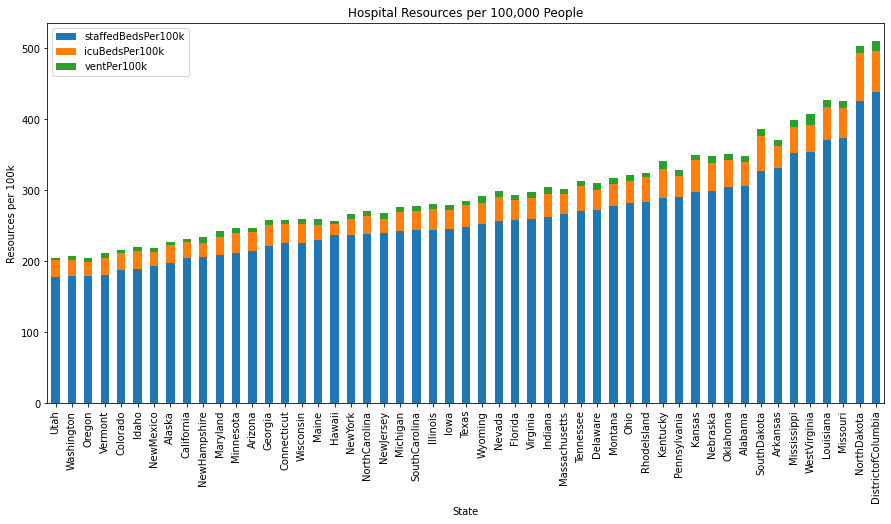

In [27]:
( 
    state_df
    .sort_values('staffedBedsPer100k')
    .set_index('state')
    [['staffedBedsPer100k', 'icuBedsPer100k', 'ventPer100k']]
    .plot.bar(stacked=True)
)

plt.title("Hospital Resources per 100,000 People")
plt.xlabel("State")
plt.ylabel("Resources per 100k")

plt.show()

We can also examine how these different measures interact with each other.

In [28]:
metric_cols = [
    'olderPerc', 
    'ventPer100k', 
    'InfluenzaRate', 
    'PneumococcalRate', 
    'staffedBedsPer100k', 
    'icuBedsPer100k',
    'deathRate'
]
state_df[metric_cols].corr(method='spearman')

,olderPerc,ventPer100k,InfluenzaRate,PneumococcalRate,staffedBedsPer100k,icuBedsPer100k,deathRate
olderPerc,1.000000,0.036652,0.193705,0.288197,0.046516,-0.180543,0.127511
ventPer100k,0.036652,1.000000,0.225747,0.110201,0.764163,0.651131,0.119005
InfluenzaRate,0.193705,0.225747,1.000000,0.941946,0.194202,0.108348,0.020909
PneumococcalRate,0.288197,0.110201,0.941946,1.000000,0.099837,0.023850,-0.014030
staffedBedsPer100k,0.046516,0.764163,0.194202,0.099837,1.000000,0.875204,-0.018914
icuBedsPer100k,-0.180543,0.651131,0.108348,0.023850,0.875204,1.000000,-0.127149
deathRate,0.127511,0.119005,0.020909,-0.014030,-0.018914,-0.127149,1.000000


Looking at rank correlations across variables, more ICU beds and staffed beds are negatively related to the death rate while ventilator usage and older percentage are slightly positively correlated. Let's visualize these pairwise correlations.

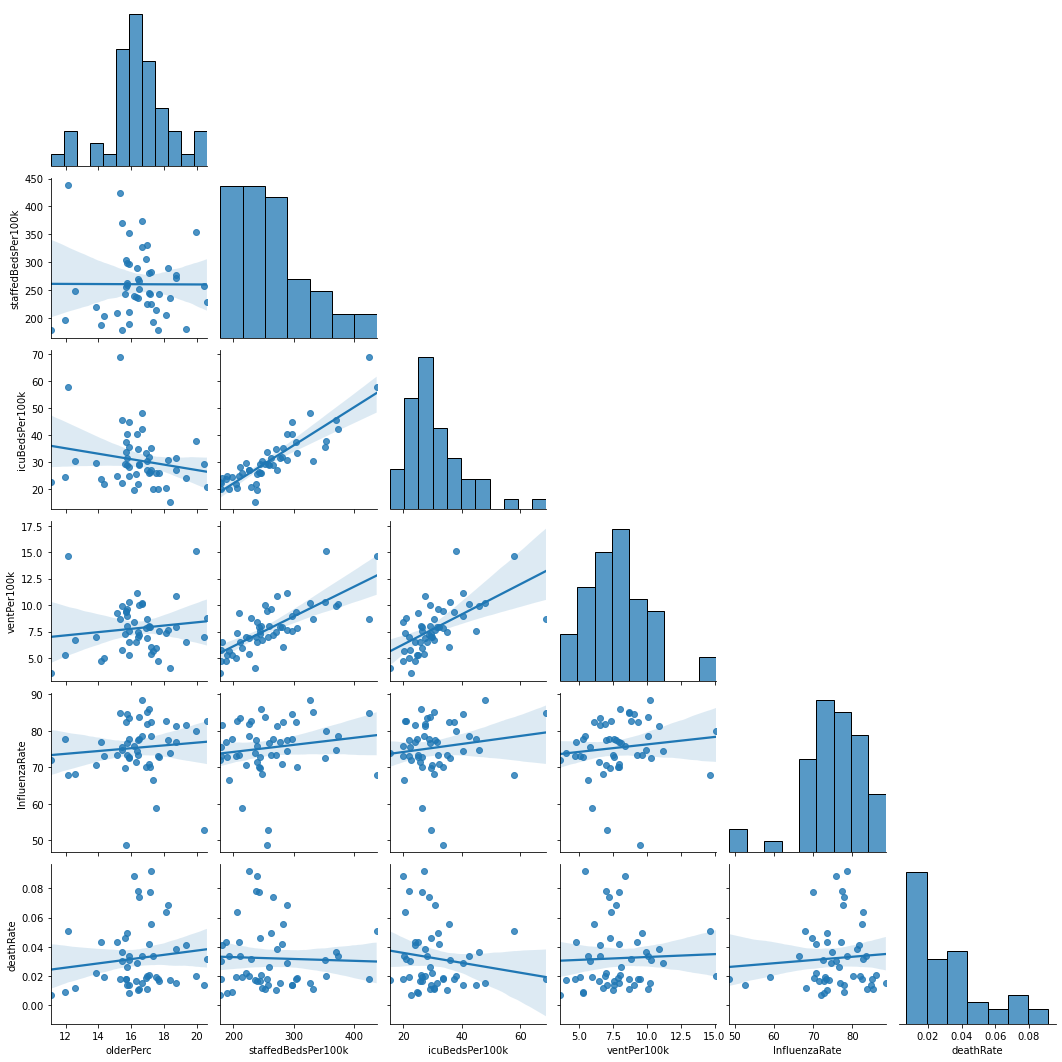

In [29]:
cols = [
    'olderPerc', 
    'staffedBedsPer100k', 
    'icuBedsPer100k', 
    'ventPer100k', 
    'InfluenzaRate',
    'deathRate'
]
sns.pairplot(state_df.loc[:, cols], kind='reg', corner=True)
plt.show()

While we can see that hospital resources are closely correlated (eg. ICU and staffed beds), relationships with the death rate are less clear cut. As we might expect, there are many factors we aren't capturing that determine the heterogeneity in population responses to the pandemic.

<a id="vaccines"></a>
### Vaccination Rates

Scientists around the world are racing to produce an effective vaccine. Beyond the significant scientific challenge this poses, distribution and community trust of vaccines may also determine how swiftly we emerge from the pandemic. States have large variation in vaccination rates for common immunizations for Influenza and Pneumococcal disease.

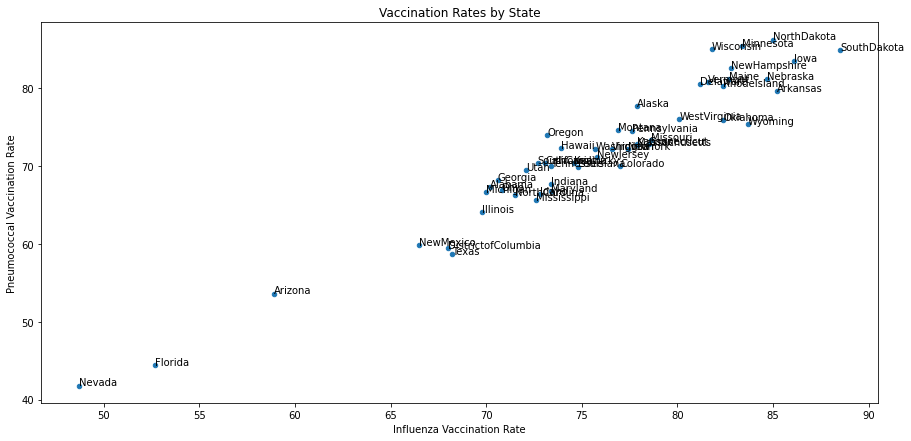

In [30]:
state_df.plot.scatter(x='InfluenzaRate', y='PneumococcalRate')

for label, x, y in zip(state_df.state, state_df.InfluenzaRate, state_df.PneumococcalRate):
        plt.annotate(label, xy=(x, y))
        
plt.title("Vaccination Rates by State")
plt.xlabel("Influenza Vaccination Rate")
plt.ylabel("Pneumococcal Vaccination Rate")

plt.show()

<a id="demographics"></a>
### Race Demographics

Finally, COVID-19 has had differential effects by demographics, and efforts are underway to increase community safety and equitable access to treatment. The Covid Tracking Project publishes case and death counts by race across the US.

In [31]:
death_demographics = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : list(states),
            "expressions" : [
                "CTP_CovidDeaths_AIAN",
                "CTP_CovidDeaths_Asian",
                "CTP_CovidDeaths_Black",
                "CTP_CovidDeaths_LatinX",
                "CTP_CovidDeaths_Multiracial",
                "CTP_CovidDeaths_NHPI",
                "CTP_CovidDeaths_Other",
                "CTP_CovidDeaths_Unknown",
                "CTP_CovidDeaths_White"
            ],
            "start" : "2020-04-01",
            "end" : "2020-09-01",
            "interval" : "DAY",
        }
    },
    get_all = True
)

In [32]:
death_demographics_states = reshapeTimeseries(death_demographics)

demographic_timeseries = (
    death_demographics_states
    .groupby(['date', 'state', 'metric'])['data']
    .sum()
    .unstack('metric')
    .reset_index()
)

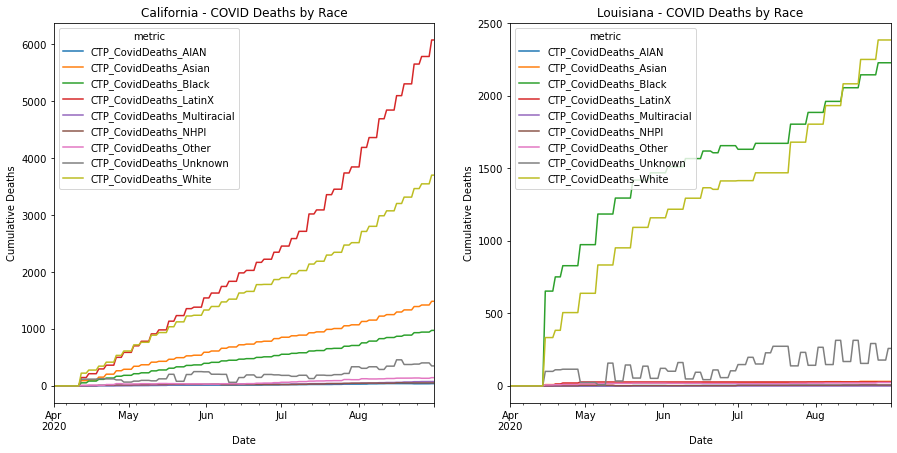

In [33]:
figure, axes = plt.subplots(1, 2)
    
(
    demographic_timeseries
    .loc[demographic_timeseries.state == 'California']
    .set_index('date')
    .plot(ax=axes[0])
)

axes[0].set_title("California - COVID Deaths by Race")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cumulative Deaths")

(
    demographic_timeseries
    .loc[demographic_timeseries.state == 'Louisiana']
    .set_index('date')
    .plot(ax=axes[1])
)
        
axes[1].set_title("Louisiana - COVID Deaths by Race")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Cumulative Deaths")

plt.show()

These plots hint at differential effects across racial and demographic groups. Additional analyses should control for share of total state population by race using US Census Bureau data. Providing greater transparency around these trends can help policy makers direct resources toward populations that need them most.

---


There are plenty of other analyses to explore. In bringing together data sets from disparate sources, the C3.ai COVID-19 Data Lake permits in-depth and real-time data exploration. 

If any publications or research results are derived in full or in part from the C3.ai COVID-19 Data Lake, please make sure to credit the C3.ai COVID-19 Data Lake by referencing the case study at https://c3.ai/customers/covid-19-data-lake/.